# spectrafit.py examples

The spectrafit module contains a set of functions used to identify peaks in experimental Raman spectra data. 

In [1]:
# import cell
import pickle
from ramannoodles import spectrafit
from ramannoodles import shoyu

In [2]:
# open spectra library
shoyu_data_dict = pickle.load(open('../raman_spectra/shoyu_data_dict.p', 'rb'))
# list keys of compounds currently downloaded and stored in the library
sorted(shoyu_data_dict.keys())

['2-PROPANOL',
 'CARBON DIOXIDE',
 'CARBON MONOXIDE',
 'DIMETHYL KETONE',
 'ETHYL ALCOHOL',
 'FORMIC ACID',
 'WATER']

In [3]:
shoyu.initialize_standard_library()

file already in raman_spectra folder
WATER loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
CARBON MONOXIDE loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
CARBON DIOXIDE loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
FORMIC ACID loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
2-PROPANOL loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
ETHYL ALCOHOL loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
DIMETHYL KETONE loaded into the dictionary - shoyu_data_dict.p


In [4]:
# extract spectra data
data = shoyu_data_dict['CARBON MONOXIDE']
x_data = data['x']
y_data = data['y']

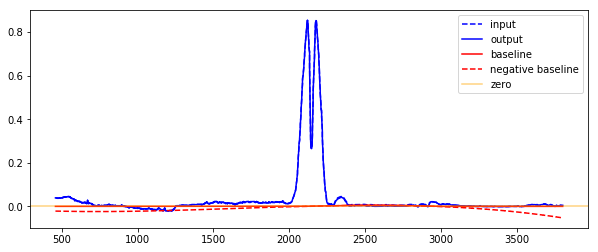

In [5]:
# subtract baseline
y_data = spectrafit.subtract_baseline(y_data, deg=3, plot=True, x_data=x_data)

In [6]:
# detect peaks
peaks, peak_list = spectrafit.peak_detect(x_data, y_data)

In [7]:
fig = plt.figure(figsize=(15,6))
plt.plot(x_data, y_data)
for i in peak_list[0]:
    plt.axvline(x=x_data[i], color='orange')

NameError: name 'plt' is not defined

In [ ]:
# assign parameters for least squares fit
mod, pars = spectrafit.lorentz_params(peaks)

In [ ]:
# fit the model to the data
out = spectrafit.model_fit(x_data, y_data, mod, pars, report=True)

In [ ]:
# plot fit results
spectrafit.plot_fit(x_data, y_data, out, plot_components=True)

In [ ]:
# export data in logical structure (see docstring)
fit_peak_data = spectrafit.export_fit_data(out)
fit_peak_data

# complete fit wrapper